In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split


# TASK 1
I am using google colabs for work, hence below import commands

In [2]:
from google.colab import files
uploaded = files.upload()

Saving bank_et1.csv to bank_et1.csv


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['bank_et1.csv']))

In [4]:
df.head(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,0,32,technician,single,tertiary,no,392,1.300134,0.473895,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,1,39,technician,divorced,secondary,no,688,-0.193701,0.237021,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,2,59,retired,married,secondary,no,1035,1.334266,0.121981,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,3,47,blue-collar,married,secondary,no,398,0.362286,1.251328,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,4,54,retired,married,secondary,no,1004,0.072075,-0.533738,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [5]:
df.tail(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,1995,20,student,single,NaN,no,2785,-2.170524,1.081071,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,1996,28,admin.,single,secondary,no,127,0.811788,1.134496,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,1997,81,retired,married,primary,no,1154,0.504655,0.042190,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,1998,46,services,married,primary,no,4343,-0.965874,0.302708,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,1999,40,entrepreneur,married,secondary,no,6403,-0.800893,1.066659,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


Housing and Loan are  suitable attributes that can be used for the target/dependable variable for 2-class classification as they only have two input options. Without having additional info on the data, as we have not been known what the attributes represent, it is not possible to say definitively which is the most suitable but hazarding a guess (not that guessing is something one should ever do in the field of data analytics), Loan looks to be the most suitable attribute for 2 class classification. Going on the presumption that this denotes customers/applicants who have been approved (yes) or not apporved (no) for a loan


# Task2

In [6]:
df.describe(include='all')

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
count,2000.000000,2000.000000,1990,2000,1896,2000,2000.000000,2000.000000,2000.000000,2000,2000,1809,2000.000000,2000,2000.000000,2000.000000,2000.000000,2000.000000,1546,2000
unique,NaN,NaN,11,3,3,2,NaN,NaN,NaN,2,2,2,NaN,12,NaN,NaN,NaN,NaN,3,2
top,NaN,NaN,management,married,secondary,no,NaN,NaN,NaN,no,no,cellular,NaN,feb,NaN,NaN,NaN,NaN,failure,yes
freq,NaN,NaN,461,1111,995,1985,NaN,NaN,NaN,1037,1750,1663,NaN,404,NaN,NaN,NaN,NaN,955,1000
mean,999.500000,41.751500,NaN,NaN,NaN,NaN,1413.663500,0.241951,0.485030,NaN,NaN,NaN,13.851500,NaN,292.020500,1.909500,167.896000,2.561500,NaN,NaN
std,577.494589,12.723077,NaN,NaN,NaN,NaN,3131.224213,0.821604,1.075543,NaN,NaN,NaN,9.712189,NaN,221.557295,1.378862,131.754126,3.400735,NaN,NaN
min,0.000000,18.000000,NaN,NaN,NaN,NaN,-980.000000,-2.632068,-2.851405,NaN,NaN,NaN,1.000000,NaN,7.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,499.750000,32.000000,NaN,NaN,NaN,NaN,201.500000,-0.308018,-0.274181,NaN,NaN,NaN,5.000000,NaN,146.000000,1.000000,75.750000,1.000000,NaN,NaN
50%,999.500000,38.000000,NaN,NaN,NaN,NaN,551.000000,0.224099,0.487082,NaN,NaN,NaN,12.000000,NaN,236.000000,1.000000,182.000000,2.000000,NaN,NaN
75%,1499.250000,50.000000,NaN,NaN,NaN,NaN,1644.500000,0.806315,1.211896,NaN,NaN,NaN,23.000000,NaN,379.000000,2.000000,251.000000,3.000000,NaN,NaN


Job, Education, Poutcome and Contact are all attibutes that show some data to be missing. Depending on the usefulenss of these attributes we may look to either remove the rows with this missing data for to fill it using values from where there is data provided for the attributes in question. Either way, none of the attibutes are showing proportionally large volumes of data to be missing.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


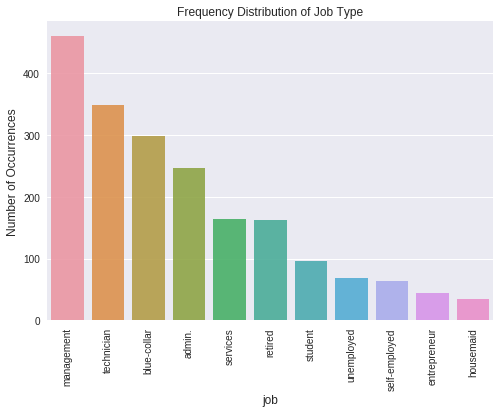

In [7]:

job_count = df['job'].value_counts()
sns.set(style="darkgrid")
sns.barplot(job_count.index, job_count.values, alpha=0.9)
plt.title('Frequency Distribution of Job Type')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('job', fontsize=12)
plt.xticks(rotation=90)
plt.show()

The above shows the Management to be the largest desciptor of job roles.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


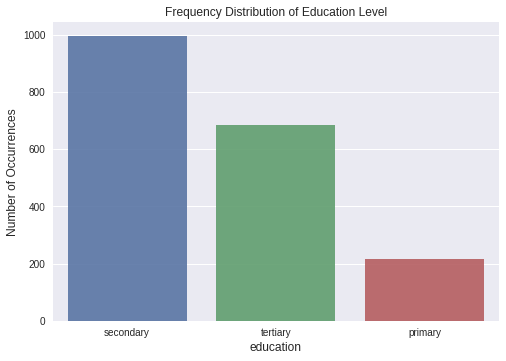

In [8]:
education_count = df['education'].value_counts()
sns.set(style="darkgrid")
sns.barplot(education_count.index, education_count.values, alpha=0.9)
plt.title('Frequency Distribution of Education Level')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('education', fontsize=12)
plt.show()

The above gives a breakdown of the levels of education, with seconday being almost 50% of the level of education achieved by the account holders.

Text(0, 0.5, 'Number of Individuals')

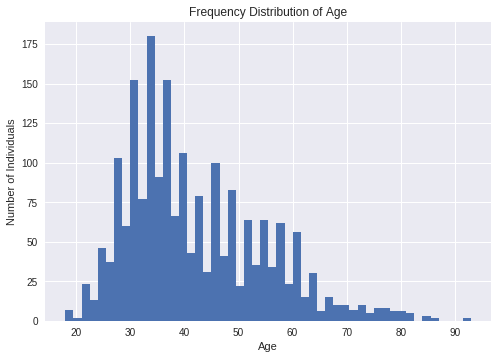

In [9]:
df['age'].hist(bins=50)
plt.title('Frequency Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Number of Individuals')

The above shows that the bulk of the individuals within the dataset are aged from 25 to 45 with some outliers, particularly on the upper end of the scale. Wit the data as it is and the upper values being plausible we have no reason to believe that these values are in error thereby there is no reason to exclude them from the dataset.

Text(0, 0.5, 'Number of Individuals')

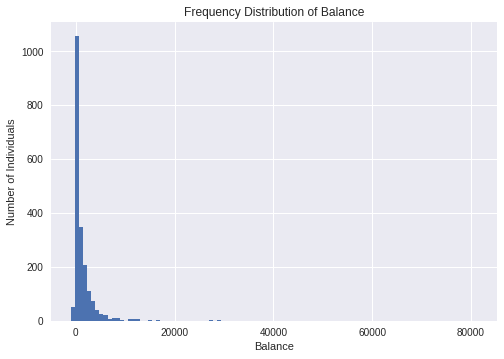

In [10]:
df['balance'].hist(bins=100)
plt.title('Frequency Distribution of Balance')
plt.xlabel('Balance')
plt.ylabel('Number of Individuals')

Looking at the balance attribute it shows that the majority of customers are somewhere around the mean value of 1413 but there is one obvious outlier of ~80,000. This may have to be cleaned/excluded in time.

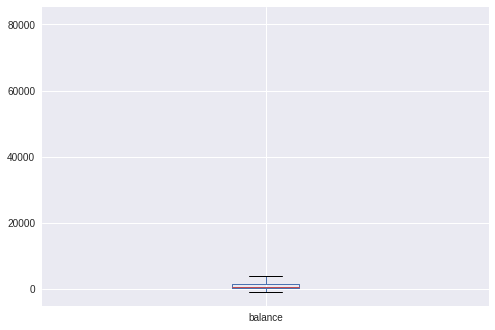

In [11]:
# Next, we look at boxplots to understand the distribution better.

df.boxplot(column='balance')

This reinforces the previous plot above.

Text(0.5, 0.98, '')

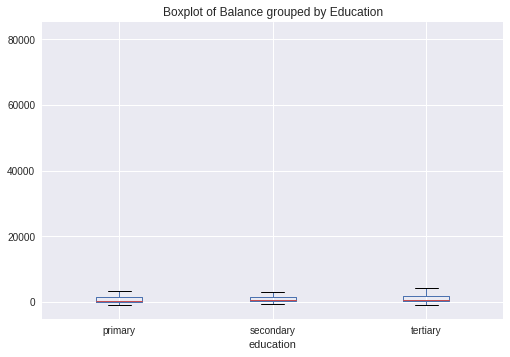

In [12]:
# Boxplots of Balance, grouped by the categorical attribute Education
df.boxplot(column='balance', by='education')
plt.title('Boxplot of Balance grouped by Education')
plt.suptitle("") # get rid of the automatic 'Boxplot grouped by group_by_column_name' title

The above box plots give a breakdown of the balance versus education levels. While all 3 levels show a similar mean range, the standard deviation of tertiary level education is muc greater. This would imply a broader spread of balance values amongst those with 3rd level education.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Age')

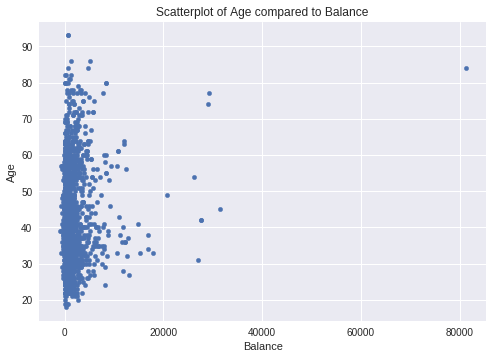

In [13]:
df.plot.scatter(x='balance', y='age')
plt.title('Scatterplot of Age compared to Balance')
plt.xlabel('Balance')
plt.ylabel('Age')

The above scatter plot compares age against balance. Despite the fact that the balance values are clustered around the mean value as mentioned above, when compared to Age it shows that similar balance values are spread right across the age spectrum

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Ratio of Loan to Income')

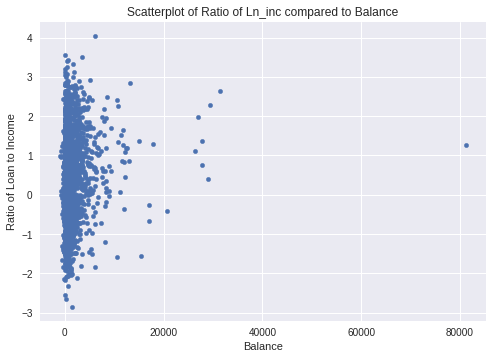

In [23]:
df.plot.scatter(x='balance', y='ratio_ln_inc')
plt.title('Scatterplot of Ratio of Ln_inc compared to Balance')
plt.xlabel('Balance')
plt.ylabel('Ratio of Loan to Income')

The above scatterpolot shows a very similar trend to the previous one, the balance values in the region of the Balance mean are spreadd right acroos the spectrum of Loan to Income Ratios

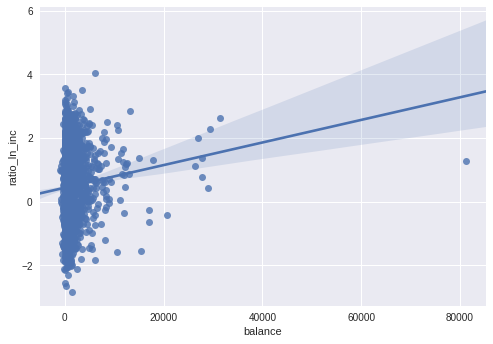

In [15]:
sns.regplot(x='balance', y='ratio_ln_inc', data=df)

Unfortunately the above reg plot doesn't offer any further clarification on the data in terms of identifying a patter between the balance and the ratio of loan to income

In [16]:
frequency_table = df['loan'].value_counts(ascending=True)
print('Frequency Table for Existing Loan:') 
print(frequency_table)

Frequency Table for Existing Loan:
yes     250
no     1750
Name: loan, dtype: int64


This shows that within the Load attribute, the majority of the individuals have no loan. This can imply already stringent criteria in the loan application process.

In [0]:
pivot_table = df.pivot_table(values='housing',
                       index=['loan'],
                       aggfunc=lambda x: x.map({'yes':1, 'no':0}).mean()) 

In [18]:
# Print pivot table
print(pivot_table)

       housing
loan          
no    0.453143
yes   0.680000


THe above shows that housing can be a big indicator of having a loan with there being a 68% probability of someone with housing having a loan.

(array([0, 1]), <a list of 2 Text xticklabel objects>)

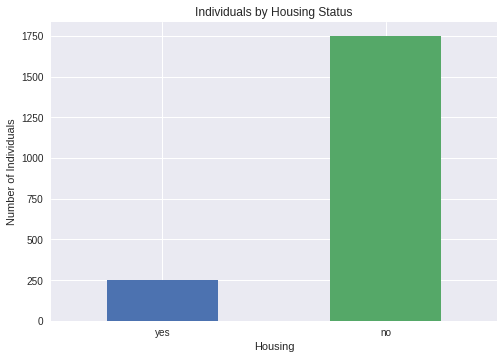

In [24]:
# Plot the frequency table for Housing Status
frequency_table.plot(kind='bar')
plt.xlabel('Housing')
plt.ylabel('Number of Individuals')
plt.title('Individuals by Housing Status')
plt.xticks(rotation='horizontal')

Eventhough the breakdown of numbers of those with housing and those not having housing is very similar to the breakdown of those with a loan and without one, the correlation isn't direct. As will be shown in the following plot.

(array([0, 1]), <a list of 2 Text xticklabel objects>)

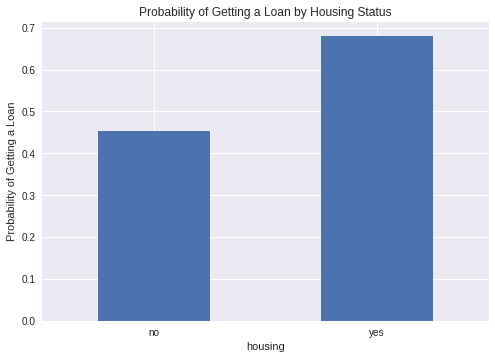

In [20]:
# Plot pivot table
pivot_table.plot(kind='bar')
plt.xlabel('housing')
plt.ylabel('Probability of Getting a Loan')
plt.title('Probability of Getting a Loan by Housing Status')
plt.legend().set_visible(False)
plt.xticks(rotation='horizontal')

Text(0, 0.5, 'Number of Individuals')

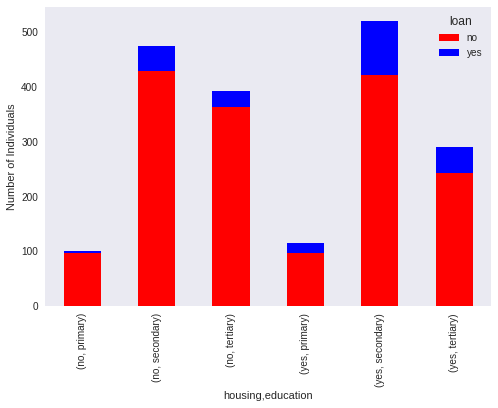

In [21]:
stacked_chart_education = pd.crosstab([df['housing'], df['education']], df['loan'])
stacked_chart_education.plot(kind='bar', stacked=True, color=['red', 'blue'], grid=False)
plt.ylabel('Number of Individuals')

The above shows that if you have housing and a secondary education you have a greater probability of getting a loan relative to the other possible scenarios combing the housing and education attributes.

Text(0, 0.5, 'Ratio_ln_in')

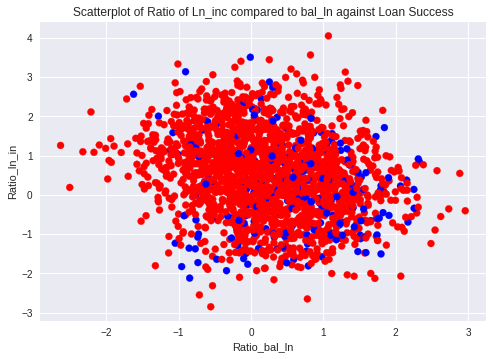

In [22]:
colors = {'yes': 'b', 'no': 'r'}

plt.scatter(df['ratio_bal_ln'], df['ratio_ln_inc'], color=[colors[r] for r in df['loan']])
plt.title('Scatterplot of Ratio of Ln_inc compared to bal_ln against Loan Success')
plt.xlabel('Ratio_bal_ln')
plt.ylabel('Ratio_ln_in')

I have chosen the Loan to Income (Ln_inc) and Balance to Loan (bal_ln) attributes to classify the Loan dependent variable. The plot above shows the comparison. As it stands they are unfortunately not linearly seperable. Although other attributes are plotted above I don't think they give an good indication in order to determine the desired dependent variable, Loan. While the two attributes chosen above are well clustered and I believe I can work with these. The Loan dependent variable is chosen purely from a practicatlity perspective. I Appreciate that it does not have an even spread of Yes/No within the 2000 samples but I don't believe an even spread of these to be a pre-requisite for a desired classification exercise.

# Task 3


  Consider the two numerical attributes picked in Task 2 and describe (in a markdown cell) how a perceptron can be used to perform 2-class classification. Use the following terms in your description:

In summary, the data provided contains bank account details for 2000 customers. This dataset will be used help the bank to predict whether future applicants should be granted a loan or not based on information provided within the dataset on previous customers. 

Below is my commentary on the various terms requested. It could well be more eloquently put and I may have some misunderstanding in there so please feel free to point them out to me but considering how difficult I am finding Task 4 I'd rather focus my time on that.

The **Input space** will be the training data set including the numerical attributes chosen above. The **Output space ** will be a level of prediction accuracy for the 2 Class Classification attribute (Loan). The **Unknown target function** will be close to or equal to the **Final Hypohtesis** which will be the optimimum set of weights applied to give us the closest proximity of the **In Sample error** rate (the error rate within the training data set) to the **Out of Sample error** (the error rate from the predicticed values for the test data set). The **Data set** is the entire sample of data which will be broken in to a test and training dataset. The **Hypothesis set** will be all the possible weight scenarios that will have been applied during the training process.



# Task 4

 Suggestion: try PLA on this dataset before using the bank dataset

In [0]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2)
y = [yy if yy == 1 else -1 for yy in y] 

In [0]:
def h(x,w):
    #Perceptron model: the sign of the dot product of weights and input vector determines the class allocation
    bias = np.array([1])
    return np.sign(w.T.dot(np.concatenate((bias,x))))

In [0]:
def point_on_boundary(weights, x):
    # Return the y-position on the boundary based on given x-position
    return -(weights[0]+weights[1]*x)/weights[2]

In [0]:
def decision_boundary(weights, x_min, x_max):
    # Return two points on the decision boundary
    return [pointOnBoundary(x_min), pointOnBoundary(x_max)]

In [0]:
def pla(training_in, training_out, weights):
    bias = np.array([1])
    iterations=0
    while True:
        errors = 0;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)!=y):
                iterations+=1;
                weights = weights + y*(np.concatenate((bias,x)))
                errors+=1;
        if (errors == 0):
            break
    return weights, iterations

In [0]:
def calc_error(training_in, training_out, weights):
    # Calculate the classification error as the fraction of training samples that are misclassified
    errors=0
    for x,y in zip(training_in, training_out):
        if (h(x,weights)!=y):
            errors+=1;
    return errors/len(training_in)

----------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd

def h(x,w):
   #Perceptron model: the sign of the dot product of weights and input vector determines the class allocation
   bias = np.array([1])
   return np.sign(w.T.dot(np.concatenate((bias,x))))

def point_on_boundary(weights, x):
   # Return the y-position on the boundary based on given x-position
   return -(weights[0]+weights[1]*x)/weights[2]
def decision_boundary(weights, x_min, x_max):
   # Return two points on the decision boundary
   return [pointOnBoundary(x_min), pointOnBoundary(x_max)]
def pla(training_in, training_out, weights):
   bias = np.array([1])
   iterations=0
   while True:
       errors = 0;
       for x,y in zip(training_in, training_out):
           if (h(x,weights)!=y):
               iterations+=1;
               weights = weights + y*(np.concatenate((bias,x)))
               errors+=1;
       if (errors == 0):
           break
   return weights, iterations
def calc_error(training_in, training_out, weights):
   # Calculate the classification error as the fraction of training samples that are misclassified
   errors=0
   for x,y in zip(training_in, training_out):
       if (h(x,weights)!=y):
           errors+=1;
   return errors/len(training_in)

#there is a bug in the code check the forum
#X, y = make_blobs(n_samples=1000, centers=2, n_features=2)
#y = [yy if yy == 1 else -1 for yy in y]
